In [2]:
#!pip install scipy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from gensim.models import KeyedVectors
# import gensim.downloader as api
import random
import os

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
#VSCODE
train_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/train.csv")
test_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/test.csv")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, stratify=train_df["label"], random_state=42)

<hr>
<hr>
<hr>

# GloVe + CNN + BiLSTM

- Following Architecture leverages:
    - GloVe: Pretrained word embeddings;
    - CNN : For extracting local features like n-gram patterns
    - BiLSTM: For capturing sequential dependencies
    - Dense: For Final Classification

Sources: https://doi.org/10.1155/2022/7212366

- Although word2vec has good lexical analogy performance, it is limited by the characteristics of local windows and is hard to use the global lexical cooccurrence statistics effectively. GloVe combines the advantages of the above two, combines the global statistical information with the local context window, and has a better effect of word vectorization.

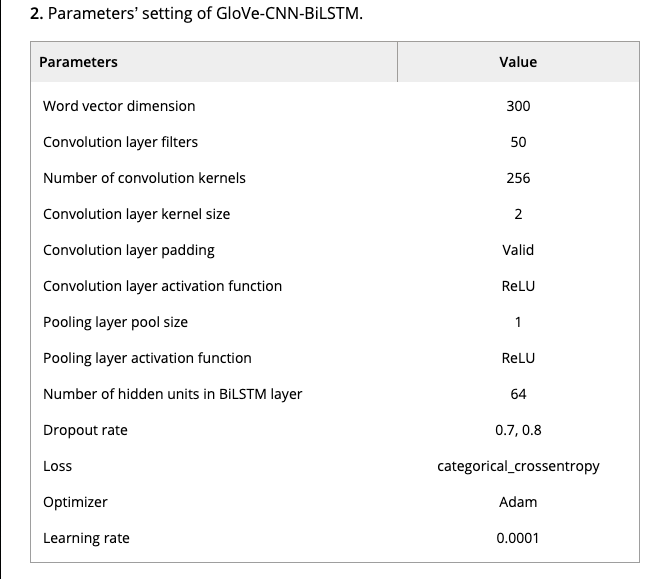

In [5]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def full_preprocess_glove(text):
    # ─── STEP 1: BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", " ", text)                     # Remove punctuation
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ─── STEP 2: TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ─── STEP 3: REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ─── STEP 4: LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


In [6]:
X_train_glove = X_train.apply(full_preprocess_glove)
X_test_glove = X_test.apply(full_preprocess_glove)

In [10]:
tweet_lengths = X_train_glove.apply(len)
tweet_lengths.describe()
maxlen = int(tweet_lengths.quantile(0.95))  # covers 95% of tweets
print(maxlen)

15


In [11]:
# Join preprocessed tokens back into strings
X_train_text = X_train_glove.apply(lambda tokens: ' '.join(tokens))
X_test_text = X_test_glove.apply(lambda tokens: ' '.join(tokens))

# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Update vocab size and word index
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

In [12]:
from itertools import chain

# Flatten all tokens across tweets into one list
all_tokens = chain.from_iterable(X_train_glove)  # if X_train_glove is a list of token lists

# Get global unique tokens
unique_vocab = set(all_tokens)

vocab_size = len(unique_vocab)
print("✅ True vocab size:", vocab_size)


✅ True vocab size: 12568


In [13]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, ReLU, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, Activation, 
                                     GlobalMaxPooling1D, Bidirectional, LSTM, 
                                     Dropout, Dense)
from tensorflow.keras.optimizers import Adam

In [50]:
import os
import zipfile
import urllib.request

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"

# Download
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)

# Unzip
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall("glove")

In [51]:
glove_path = "glove/glove.6B.300d.txt"


In [52]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=300):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix


In [ ]:
embedding_dim = 300

embedding_matrix = load_glove_embeddings(glove_path, word_index, embedding_dim)

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input_layer)

In [79]:
conv_layer = Conv1D(
    filters=256,
    kernel_size=2,
    padding="valid",
    activation="relu"
)(embedding_layer)
from tensorflow.keras.layers import BatchNormalization

x = BatchNormalization()(conv_layer)
pool = GlobalMaxPooling1D()(x)

bilstm = Bidirectional(LSTM(128, return_sequences=False))(x)

# Concatenate CNN + BiLSTM outputs
from tensorflow.keras.layers import concatenate
merged = concatenate([pool, bilstm])

dropout = Dropout(0.5)(merged)
output_layer = Dense(3, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 33, 300)   │  3,770,100 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 32, 256)   │    153,856 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 256)   │      1,024 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 256)       │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 3)         │      1,539 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,320,759 (16.48 MB)

 Trainable params: 4,320,247 (16.48 MB)

 Non-trainable params: 512 (2.00 KB)

In [80]:
history = model.fit(X_train_pad, y_train,
                    epochs=60,
                    batch_size=32,
                    validation_data=(X_test_pad, y_test))


Epoch 1/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.2626 - loss: 5.1725 - val_accuracy: 0.4657 - val_loss: 1.0629
Epoch 2/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.4321 - loss: 3.1181 - val_accuracy: 0.6260 - val_loss: 1.1870
Epoch 3/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5005 - loss: 2.8433 - val_accuracy: 0.6475 - val_loss: 1.3429
Epoch 4/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.5346 - loss: 2.4836 - val_accuracy: 0.6600 - val_loss: 1.3378
Epoch 5/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.5399 - loss: 2.5482 - val_accuracy: 0.6663 - val_loss: 1.3187
Epoch 6/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.5495 - loss: 2.5161 - val_accuracy: 0.6768 - val_loss: 1.2340
Epoch 7/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.5715 - loss: 2.2725 - val_accuracy: 0.6805 - val_loss: 1.2134
Epoch 8/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.5776 - loss: 2.2356 - 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<hr>
<hr>
<hr>